In [56]:
from torchvision import transforms, datasets, models
import torch.nn as nn
import torch.optim as optim
import torch
import time
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os
import torch
from torch.utils.data import random_split, DataLoader
from torch.utils.data import Subset
import pandas as pd
import seaborn as sns

In [37]:
# Image transforms
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [38]:
# Path to dataset
data_dir = 'C:/Users/Омар/FinalAnalysis/AiFinal/.venv/data_trash'
batch_size = 32
num_classes = 6
seed = 42

In [39]:
# Load entire dataset temporarily (with dummy transform)
full_dataset = datasets.ImageFolder(root=data_dir, transform=transforms.ToTensor())

In [40]:
# Split dataset into train/val/test
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
valid_size = int(0.1 * total_size)
test_size = total_size - train_size - valid_size

In [41]:
torch.manual_seed(seed)
train_idx, valid_idx, test_idx = random_split(full_dataset, [train_size, valid_size, test_size])

In [42]:
# Reassign transforms per subset
train_set = Subset(datasets.ImageFolder(root=data_dir, transform=image_transforms['train']), train_idx.indices)
valid_set = Subset(datasets.ImageFolder(root=data_dir, transform=image_transforms['valid']), valid_idx.indices)
test_set  = Subset(datasets.ImageFolder(root=data_dir, transform=image_transforms['test']),  test_idx.indices)

In [43]:
# Create dataloaders
train_data = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_data = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_data  = DataLoader(test_set,  batch_size=batch_size, shuffle=False)

In [44]:
print(f"Train: {len(train_set)}, Valid: {len(valid_set)}, Test: {len(test_set)}")
print(f"Classes: {full_dataset.classes}")

Train: 350, Valid: 50, Test: 100
Classes: ['cans', 'food', 'glass', 'paper', 'plastic']


In [46]:
# Load model
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

fc_inputs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes),
    nn.LogSoftmax(dim=1)
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss and optimizer
loss_criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [48]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

epochs = 20
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    model.train()
    train_loss, train_acc = 0.0, 0.0
    loop = tqdm(train_data, desc="Training", leave=False)
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs.data, 1)
        train_acc += torch.sum(preds == labels).item()
        loop.set_postfix(loss=loss.item())

    train_losses.append(train_loss / len(train_data.dataset))
    train_accuracies.append(train_acc / len(train_data.dataset))

    # Validation
    model.eval()
    val_loss, val_acc = 0.0, 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        loop = tqdm(valid_data, desc="Validating", leave=False)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs.data, 1)
            val_acc += torch.sum(preds == labels).item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            loop.set_postfix(loss=loss.item())

    val_losses.append(val_loss / len(valid_data.dataset))
    val_accuracies.append(val_acc / len(valid_data.dataset))

    print(f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")


Epoch 1/20


Val Loss: 1.2482, Val Accuracy: 0.5600

Epoch 2/20


Val Loss: 0.9410, Val Accuracy: 0.6800

Epoch 3/20


Val Loss: 0.5542, Val Accuracy: 0.8200

Epoch 4/20


Val Loss: 0.7239, Val Accuracy: 0.7400

Epoch 5/20


Val Loss: 0.7231, Val Accuracy: 0.7400

Epoch 6/20


Val Loss: 0.6898, Val Accuracy: 0.7800

Epoch 7/20


Val Loss: 0.6835, Val Accuracy: 0.7600

Epoch 8/20


Val Loss: 0.8223, Val Accuracy: 0.7000

Epoch 9/20


Val Loss: 0.9063, Val Accuracy: 0.6800

Epoch 10/20


Val Loss: 0.7525, Val Accuracy: 0.7400

Epoch 11/20


Val Loss: 0.6691, Val Accuracy: 0.7600

Epoch 12/20


Val Loss: 0.8360, Val Accuracy: 0.7200

Epoch 13/20


Val Loss: 1.0561, Val Accuracy: 0.7000

Epoch 14/20


Val Loss: 0.7054, Val Accuracy: 0.7600

Epoch 15/20


Val Loss: 0.6538, Val Accuracy: 0.7800

Epoch 16/20


Val Loss: 0.8128, Val Accuracy: 0.8000

Epoch 17/20


Val Loss: 0.9464, Val Accuracy: 0.7400

Epoch 18/20


Val Loss: 0.6806, Val Accuracy: 0.8200

Epoch 19/20


Val Loss: 0.8805, Val Accuracy: 0.7600

Epoch 20/20


Val Loss: 0.5968, Val Accuracy: 0.8200


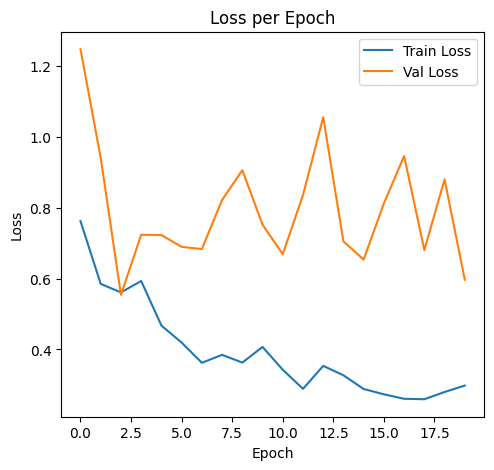

In [49]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

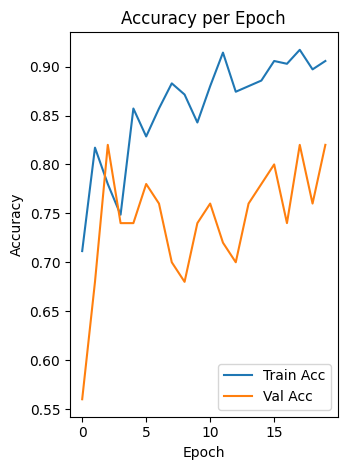

In [50]:
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


Classification Report:
              precision    recall  f1-score   support

        cans       0.43      0.75      0.55         4
        food       0.82      0.82      0.82        11
       glass       0.90      0.90      0.90        10
       paper       0.92      0.92      0.92        12
     plastic       0.90      0.69      0.78        13

    accuracy                           0.82        50
   macro avg       0.79      0.82      0.79        50
weighted avg       0.85      0.82      0.83        50



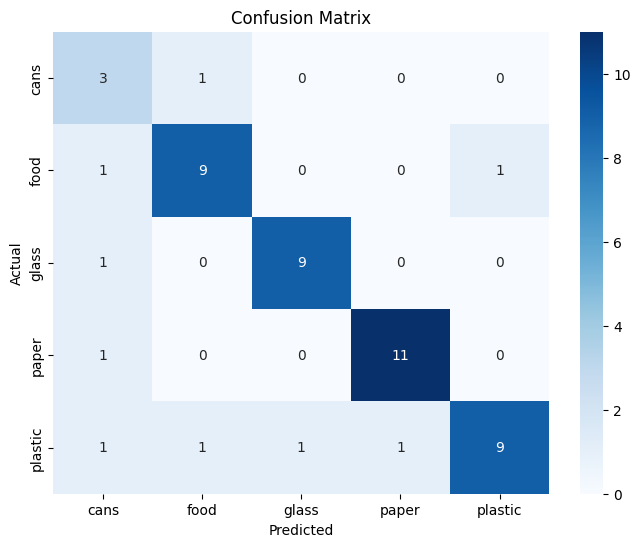

In [57]:
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

conf_matrix = confusion_matrix(all_labels, all_preds)
df_cm = pd.DataFrame(conf_matrix, index=full_dataset.classes, columns=full_dataset.classes)
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [65]:
# Ensure ASCII-safe and permission-safe path
model_dir = '//'
os.makedirs(model_dir, exist_ok=True)
filepath = os.path.join(model_dir, 'trashnetV2.pt')

In [66]:
# Save model
torch.save(model.state_dict(), filepath)
print(f"Model saved to {filepath}")

Model saved to C:/Users/Омар/FinalAnalysis/AiFinal/trashnetV2.pt


In [67]:
# Define class names based on folder order in your dataset
class_names = [
    'cardboard',
    'glass',
    'metal',
    'paper',
    'plastic',
    'trash'
]

In [69]:
def predict(model, image_path):
    image_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert("RGB")
    transformed = image_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(transformed)
        _, predicted = output.max(1)

    return predicted.item(), image


In [70]:
def make_prediction(model_path, image_path):
    model = models.resnet50(pretrained=False)
    fc_inputs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(fc_inputs, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, 6),
        nn.LogSoftmax(dim=1)
    )

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    predicted_idx, original_image = predict(model, image_path)
    predicted_label = class_names[predicted_idx]

    # Show image with prediction
    plt.imshow(original_image)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

    return predicted_label

In [71]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

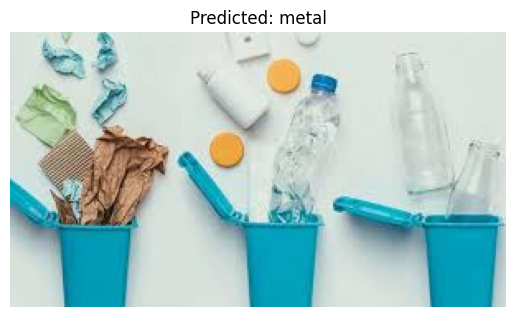

Predicted class: metal


In [35]:
# Entry point
if __name__ == '__main__':
    model_path = '../trashnetv2.pt'  # Adjust as needed
    image_path = '../data_trash/glass/images-2.jpeg'  # Replace with your test image path

    result = make_prediction(model_path, image_path)
    print("Predicted class:", result)